# Informe nº7.1
    Notas: breve actualización del TFG. Actualización/mejora del método propuesto en el infome 7.
    Fecha: 07/08/2020 - 12/08/2020
   
   ### Modificación del método propuesto en el informe anterior
   
   ### Comparacion del método actualizado con el anterior

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install pvlib
!pip install pyephem
!pip install pandas
!pip install datetime
!pip install sklearn
!pip install seaborn

import cv2
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sn
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pvlib as pv
from datetime import datetime as dt
from datetime import timedelta
from glob import glob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from mascaras import *
from funciones_algoritmo import *
from muestra_imagenes import *

### Modificación del método propuesto en el informe anterior
    En el informe 7 se ha propuesto un método para estimar la radiación difusa de un sector basado en el cálculo del número de píxeles de cielo/nubes que se encuentran en un determinado ángulo sólido. Este método supone que la radiación difusa percibida es uniforme en todo el cielo, una suposición que es correcta en cielos despejados, pero no en cielos nublados. En este tipos de cielos, las nubes pueden presentar distinta intensidad en función del tipo al que correspondan.
    Por estos motivos, se cree que puede ser una mejor aproximación calcular la intensidad de los píxeles que se encuentran en el sector especificado y obtener la fracción a la que corresponde de la intensidad total de la imágen. 

### Cielos despejados

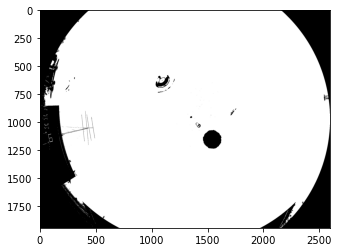

In [2]:
# Pre-procesado de la imágen
path_img_despejado = 'Fotos Cielo/imagen_original_2020-05-20-14h49min.jpg'
img_despejado = cv2.imread(path_img_despejado, cv2.IMREAD_COLOR)
img_despejado = pre_procesado(img_despejado)

# Se obtiene la hora de la imágen
hora_img = hora_imagen(path_img_despejado)
res_sol = sol_cubierto(img_despejado, hora_img)

if res_sol != 0:
    factor_solar, centroide_img, area_solar, circularidad  = res_sol

# Se obtienen las máscaras del cielo y de las nubes de la imágenes
mask_nubes = mascara_nubes(img_despejado, centroide_img)
mask_cielo = cv2.bitwise_not(mask_nubes, mask=cielo)

mask_sol = mascara_solar(img_despejado)
mask_no_sol = cv2.bitwise_not(mask_sol, mask=cielo)
mask_cielo = cv2.bitwise_and(mask_cielo, mask_no_sol, mask=cielo)

muestra_imagen(mask_cielo)

In [3]:
# Método antiguo
N = 4
# N = rand(0:5)

azimuts = [360/N*i for i in range(N+1)]

matriz_posicion = matriz_posiciones()
pixels_zeniths = matriz_posicion[:,:,0]
pixels_azimuths = matriz_posicion[:,:,1]

n=0; ratio_cielo_despejado_total=0;
for azimut in azimuts:
    max_azimut = azimut
    if max_azimut != 0:
        mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
        mask_A = cv2.bitwise_and(mask_A, cielo)
    
        # plt.figure(n)
        # muestra_imagen(cv2.bitwise_and(img_despejado, img_despejado, mask=mask_A))
        
        cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_cielo, mask_A, mask=cielo))
        cielo_despejado_total = cv2.countNonZero(mask_cielo)
        ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total
        
        print('La radiación difusa percibida en el sector {:} del cielo es: {:.2f} % del total'.format(n, ratio_cielo_despejado*100))
        ratio_cielo_despejado_total += ratio_cielo_despejado
    n+=1
    min_azimut = azimut

print('El ratio total de radiación cubierto por los sectores es {:.2f} %'.format(ratio_cielo_despejado_total*100))

C:\Users\nitra\Documents\GitHub\Camara\funciones_algoritmo.py:272: RuntimeWarning: divide by zero encountered in long_scalars
  alpha = np.rad2deg(np.arctan(delta_x / delta_y))
C:\Users\nitra\Documents\GitHub\Camara\funciones_algoritmo.py:272: RuntimeWarning: invalid value encountered in long_scalars
  alpha = np.rad2deg(np.arctan(delta_x / delta_y))


La radiación difusa percibida en el sector 1 del cielo es: 25.34 % del total
La radiación difusa percibida en el sector 2 del cielo es: 22.50 % del total
La radiación difusa percibida en el sector 3 del cielo es: 25.64 % del total
La radiación difusa percibida en el sector 4 del cielo es: 26.61 % del total
El ratio total de radiación cubierto por los sectores es 100.08 %


In [4]:
# Método actualizado
N = 4

azimuts = [360/N*i for i in range(N+1)]

img_sector_cielo = gamma_corr(cv2.bitwise_and(img_despejado, img_despejado, mask=mask_cielo))
cielo_despejado_total = np.sum(intensidad_ITUR(img_sector_cielo))

n=0; ratio_cielo_despejado_total=0;
for azimut in azimuts:
    max_azimut = azimut
    if max_azimut != 0:
        mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
        mask_A = cv2.bitwise_and(mask_A, cielo)
        
        # Se muestra el sector correspondiente
        img_sector = cv2.bitwise_and(img_despejado, img_despejado, mask=mask_A)
        # plt.figure(n)
        # muestra_imagen(img_sector)
        
        img_sector = np.array(gamma_corr(img_sector), np.uint8)
        
        mask_cielo_ang_sol = cv2.bitwise_and(mask_cielo, mask_A, mask=cielo)
        img_sector_cielo_ang_sol = cv2.bitwise_and(img_sector, img_sector, mask=mask_cielo_ang_sol)
        cielo_ang_sol = np.sum(intensidad_ITUR(img_sector_cielo_ang_sol))
        
        # Estimación de la radiación en este sector
        ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total      
        print('La radiación difusa percibida en el sector {:} del cielo es: {:.2f} % de la total'.format(n, ratio_cielo_despejado*100))
        ratio_cielo_despejado_total += ratio_cielo_despejado
    n+=1
    min_azimut = azimut
    
print('El ratio total de radiación cubierto por los sectores es {:.2f} %'.format(ratio_cielo_despejado_total*100))

La radiación difusa percibida en el sector 1 del cielo es: 24.07 % de la total
La radiación difusa percibida en el sector 2 del cielo es: 22.19 % de la total
La radiación difusa percibida en el sector 3 del cielo es: 27.47 % de la total
La radiación difusa percibida en el sector 4 del cielo es: 26.35 % de la total
El ratio total de radiación cubierto por los sectores es 100.08 %


#### Resultados de los dos métodos:
   * Informe 7:
        + Sector 1: 25.34 % 
        + Sector 2: 22.50 %
        + Sector 3: 25.64 %
        + Sector 4: 26.61 %
        + Total: 100.08 %
        
   * Actualizado: 
        + Sector 1: 24.01 %
        + Sector 2: 22.13 %
        + Sector 3: 27.40 %
        + Sector 4: 26.28 %
        + Total: 99.83 %

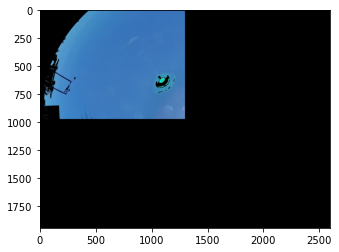

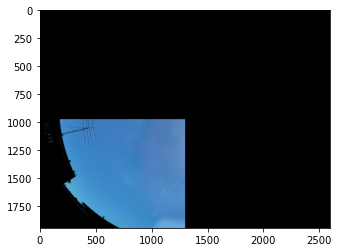

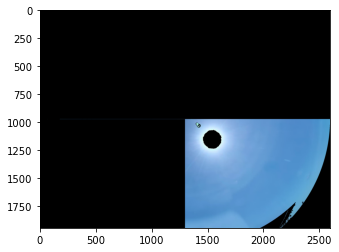

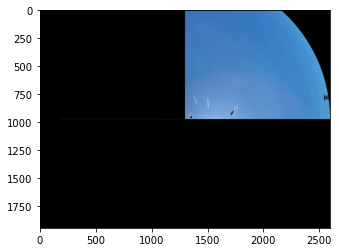

In [5]:
n=0;
for azimut in azimuts:
    max_azimut = azimut
    if max_azimut != 0:
        mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
        mask_A = cv2.bitwise_and(mask_A, cielo)
        mask_cielo_ang_sol = cv2.bitwise_and(mask_cielo, mask_A, mask=cielo)
        
    
        img_sector = cv2.bitwise_and(img_despejado, img_despejado, mask=mask_cielo_ang_sol)
        plt.figure(n)
        muestra_imagen(img_sector)
    n+=1
    min_azimut = azimut

Observamos que el sector 4 es el que debería presentar una mayor fracción de radiación, seguido del tercero y el primero, y por último, en el que menor fracción debería haber es el segundo. Esto se cumple en el método del informe 7 y no en el actualizado, ya que el resultado queda ligeramente modificado por los píxeles saturados que se encuentran cerca del disco solar en el sector 3. En este tipo de cielos, despejados, el método actualizado puede presentar ligeros erores.

### Cielos nublados


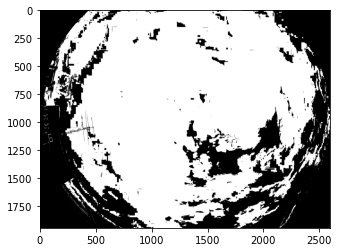

In [6]:
# Pre-procesado de la imágen
path_img_nublado = 'Fotos Cielo/imagen_original_2020-05-10-15h56min.jpg'
img_nublado = cv2.imread(path_img_nublado, cv2.IMREAD_COLOR)
img_nublado = pre_procesado(img_nublado)

# Se obtiene la hora de la imágen
hora_img = hora_imagen(path_img_nublado)
res_sol = sol_cubierto(img_nublado, hora_img)

if res_sol != 0:
    factor_solar, centroide_img, area_solar, circularidad  = res_sol

# Se obtiene las máscara de nubes y cielo de la imágen
mask_nubes = mascara_nubes(img_nublado)
mask_cielo = cv2.bitwise_not(mask_nubes, mask=cielo)

muestra_imagen(mask_nubes)

In [7]:
# División del cielo en N sectores definidos por los ángulos azimutales y cenitales
N = 4
# N = rand(0:5)

n=0; ratio_cielo_nublado_total=0
for azimut in azimuts:
    max_azimut = azimut
    if max_azimut != 0:
        mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
        mask_A = cv2.bitwise_and(mask_A, cielo)
    
        # plt.figure(n)
        # muestra_imagen(cv2.bitwise_and(img_nublado, img_nublado, mask=mask_A))
        
        cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_nubes, mask_A, mask=cielo))
        cielo_nublado_total = cv2.countNonZero(mask_nubes)
        ratio_cielo_nublado = cielo_ang_sol / cielo_nublado_total
        
        print('La radiación difusa percibida en el sector {:} del cielo es: {:.2f} % del total'.format(n, ratio_cielo_nublado*100))
        ratio_cielo_nublado_total += ratio_cielo_nublado
    n+=1
    min_azimut = azimut
    
print('El ratio total de radiación cubierto por los sectores es {:.2f} %'.format(ratio_cielo_nublado_total*100))

La radiación difusa percibida en el sector 1 del cielo es: 29.25 % del total
La radiación difusa percibida en el sector 2 del cielo es: 23.31 % del total
La radiación difusa percibida en el sector 3 del cielo es: 17.21 % del total
La radiación difusa percibida en el sector 4 del cielo es: 30.33 % del total
El ratio total de radiación cubierto por los sectores es 100.09 %


In [8]:
# Método actualizado
N = 4

img_sector_cielo = gamma_corr(cv2.bitwise_and(img_nublado, img_nublado, mask=mask_nubes))
cielo_nublado_total = np.sum(intensidad_ITUR(img_sector_cielo))

n=0; ratio_cielo_nublado_total=0;
for azimut in azimuts:
    max_azimut = azimut
    if max_azimut != 0:
        mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
        mask_A = cv2.bitwise_and(mask_A, cielo)
        
        # Se muestra el sector correspondiente
        img_sector = cv2.bitwise_and(img_nublado, img_nublado, mask=mask_A)
        # plt.figure(n)
        # muestra_imagen(img_sector)
        
        img_sector = np.array(gamma_corr(img_sector), np.uint8)
        
        mask_cielo_ang_sol = cv2.bitwise_and(mask_nubes, mask_A, mask=cielo)
        img_sector_nubes_ang_sol = cv2.bitwise_and(img_sector, img_sector, mask=mask_cielo_ang_sol)
        cielo_ang_sol = np.sum(intensidad_ITUR(img_sector_nubes_ang_sol))
        
        # Estimación de la radiación en este sector
        ratio_cielo_nublado = cielo_ang_sol / cielo_nublado_total      
        print('La radiación difusa percibida en el sector {:} del cielo es: {:.2f} % de la total'.format(n, ratio_cielo_nublado*100))
        ratio_cielo_nublado_total += ratio_cielo_nublado
    n+=1
    min_azimut = azimut
    
print('El ratio total de radiación cubierto por los sectores es {:.2f} %'.format(ratio_cielo_nublado_total*100))

La radiación difusa percibida en el sector 1 del cielo es: 28.39 % de la total
La radiación difusa percibida en el sector 2 del cielo es: 23.16 % de la total
La radiación difusa percibida en el sector 3 del cielo es: 18.65 % de la total
La radiación difusa percibida en el sector 4 del cielo es: 29.90 % de la total
El ratio total de radiación cubierto por los sectores es 100.09 %


#### Resultados de los dos métodos:
   * Informe 7:
        + Sector 1: 29.25 %
        + Sector 2: 23.31 %
        + Sector 3: 17.21 %
        + Sector 4: 30.33 %
        + Total: 100.09 %
        
   * Actualizado: 
        + Sector 1: 28.31 %
        + Sector 2: 23.10 %
        + Sector 3: 18.60 %
        + Sector 4: 29.82 %
        + Total: 99.83 %

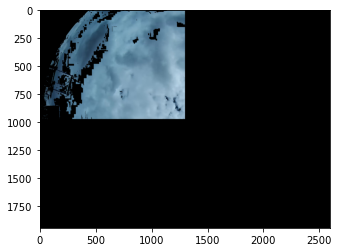

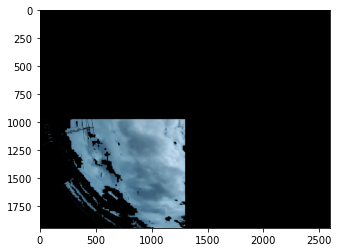

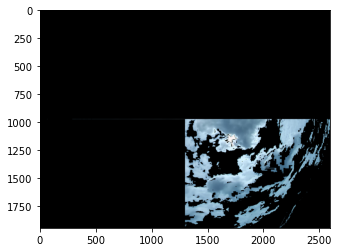

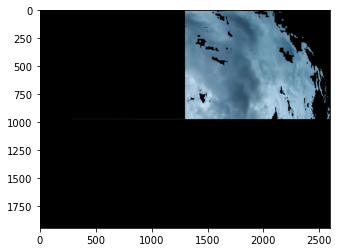

In [9]:
n=0;
for azimut in azimuts:
    max_azimut = azimut
    if max_azimut != 0:
        mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
        mask_A = cv2.bitwise_and(mask_A, cielo)
        mask_cielo_ang_sol = cv2.bitwise_and(mask_nubes, mask_A, mask=cielo)
        
    
        img_sector = cv2.bitwise_and(img_nublado, img_nublado, mask=mask_cielo_ang_sol)
        plt.figure(n)
        muestra_imagen(img_sector)
    n+=1
    min_azimut = azimut

Podemos observar que en el método actualizado los sectores con nubes con unas tonalidades más claras, 3 y 4, presentan un mayor porcentaje que en el método del informe 7. Teóricamente, este tipo de sectores son lo que debería emitir una radiación difusa mayor, y que queda reflejado con este nuevo método.

In [10]:
def comparacion(path_img_nublado):
    # Pre-procesado de la imágen
    img_nublado = cv2.imread(path_img_nublado, cv2.IMREAD_COLOR)
    img_nublado = pre_procesado(img_nublado)
    muestra_imagen(img_nublado)

    # Se obtiene la hora de la imágen
    hora_img = hora_imagen(path_img_nublado)
    res_sol = sol_cubierto(img_nublado, hora_img)

    if res_sol != 0:
        factor_solar, centroide_img, area_solar, circularidad  = res_sol

    # Se obtiene las máscara de nubes y cielo de la imágen
    mask_nubes = mascara_nubes(img_nublado)
    mask_cielo = cv2.bitwise_not(mask_nubes, mask=cielo)

    # División del cielo en N sectores definidos por los ángulos azimutales y cenitales
    N = 4
    # N = rand(0:5)

    print('Resultados método Informe 7:')
    n=0; ratio_cielo_nublado_total=0
    for azimut in azimuts:
        max_azimut = azimut
        if max_azimut != 0:
            mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
            mask_A = cv2.bitwise_and(mask_A, cielo)

            # plt.figure(n)
            # muestra_imagen(cv2.bitwise_and(img_nublado, img_nublado, mask=mask_A))

            cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_nubes, mask_A, mask=cielo))
            cielo_nublado_total = cv2.countNonZero(mask_nubes)
            ratio_cielo_nublado = cielo_ang_sol / cielo_nublado_total

            print('La radiación difusa percibida en el sector {:} del cielo es: {:.2f} % del total'.format(n, ratio_cielo_nublado*100))
            ratio_cielo_nublado_total += ratio_cielo_nublado
        n+=1
        min_azimut = azimut

    print('El ratio total de radiación cubierto por los sectores es {:.2f} %'.format(ratio_cielo_nublado_total*100), end='\n\n')


    print('Resultados método actualizado:')
    img_sector_cielo = gamma_corr(cv2.bitwise_and(img_nublado, img_nublado, mask=mask_nubes))
    cielo_nublado_total = np.sum(intensidad_ITUR(img_sector_cielo))

    n=0; ratio_cielo_nublado_total=0;
    for azimut in azimuts:
        max_azimut = azimut
        if max_azimut != 0:
            mask_A = cv2.inRange(pixels_azimuths, min_azimut, max_azimut)
            mask_A = cv2.bitwise_and(mask_A, cielo)

            # Se muestra el sector correspondiente
            img_sector = cv2.bitwise_and(img_nublado, img_nublado, mask=mask_A)
            # plt.figure(n)
            # muestra_imagen(img_sector)

            img_sector = np.array(gamma_corr(img_sector), np.uint8)

            mask_cielo_ang_sol = cv2.bitwise_and(mask_nubes, mask_A, mask=cielo)
            img_sector_nubes_ang_sol = cv2.bitwise_and(img_sector, img_sector, mask=mask_cielo_ang_sol)
            cielo_ang_sol = np.sum(intensidad_ITUR(img_sector_nubes_ang_sol))

            # Estimación de la radiación en este sector
            ratio_cielo_nublado = cielo_ang_sol / cielo_nublado_total      
            print('La radiación difusa percibida en el sector {:} del cielo es: {:.2f} % de la total'.format(n, ratio_cielo_nublado*100))
            ratio_cielo_nublado_total += ratio_cielo_nublado
        n+=1
        min_azimut = azimut

    print('El ratio total de radiación cubierto por los sectores es {:.2f} %'.format(ratio_cielo_nublado_total*100))

### Recopilación de varias imágenes de cielos nublados

Resultados método Informe 7:
La radiación difusa percibida en el sector 1 del cielo es: 33.11 % del total
La radiación difusa percibida en el sector 2 del cielo es: 45.92 % del total
La radiación difusa percibida en el sector 3 del cielo es: 17.38 % del total
La radiación difusa percibida en el sector 4 del cielo es: 3.70 % del total
El ratio total de radiación cubierto por los sectores es 100.11 %

Resultados método actualizado:
La radiación difusa percibida en el sector 1 del cielo es: 31.83 % de la total
La radiación difusa percibida en el sector 2 del cielo es: 46.62 % de la total
La radiación difusa percibida en el sector 3 del cielo es: 18.07 % de la total
La radiación difusa percibida en el sector 4 del cielo es: 3.59 % de la total
El ratio total de radiación cubierto por los sectores es 100.11 %


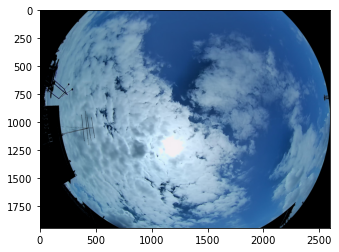

In [11]:
comparacion('Fotos Cielo/imagen_original_2020-05-13-13h11min.jpg')

Observamos que, en cielos en los que el tipo de nubes son similares, los resultados de ambos métodos son muy parecidos. También podemos comentar que los resultados obtenidos presentan cierta lógica, siendo el sector de mayor radiación el tercero, presentando la mayor cantidad de nubes, seguido del segundo y tercero, y por último, el sector cuatro, en el que se observa poca cantidad de nubes y a una distancia de la cámara elevada.

Resultados método Informe 7:
La radiación difusa percibida en el sector 1 del cielo es: 13.58 % del total
La radiación difusa percibida en el sector 2 del cielo es: 25.49 % del total
La radiación difusa percibida en el sector 3 del cielo es: 31.51 % del total
La radiación difusa percibida en el sector 4 del cielo es: 29.53 % del total
El ratio total de radiación cubierto por los sectores es 100.12 %

Resultados método actualizado:
La radiación difusa percibida en el sector 1 del cielo es: 13.25 % de la total
La radiación difusa percibida en el sector 2 del cielo es: 24.28 % de la total
La radiación difusa percibida en el sector 3 del cielo es: 32.59 % de la total
La radiación difusa percibida en el sector 4 del cielo es: 30.00 % de la total
El ratio total de radiación cubierto por los sectores es 100.11 %


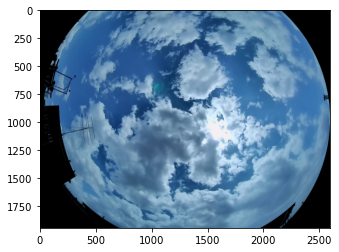

In [12]:
comparacion('Fotos Cielo/imagen_original_2020-06-04-15h07min.jpg')

La mayor diferencia la encontramos en el sector 2 y 3, en el que el método actualizado debería obtener mejores resultados, ya que observamos que la luminancia de estos sectores es completamente diferente, en el sector 2 las nubes presentan una tonalidad mas oscuara, frente al sector 3 donde observamos nubes muy claras, sobretodo en las zonas cercanas al sol.

Resultados método Informe 7:
La radiación difusa percibida en el sector 1 del cielo es: 27.84 % del total
La radiación difusa percibida en el sector 2 del cielo es: 22.68 % del total
La radiación difusa percibida en el sector 3 del cielo es: 37.67 % del total
La radiación difusa percibida en el sector 4 del cielo es: 11.94 % del total
El ratio total de radiación cubierto por los sectores es 100.13 %

Resultados método actualizado:
La radiación difusa percibida en el sector 1 del cielo es: 27.98 % de la total
La radiación difusa percibida en el sector 2 del cielo es: 23.15 % de la total
La radiación difusa percibida en el sector 3 del cielo es: 36.96 % de la total
La radiación difusa percibida en el sector 4 del cielo es: 12.04 % de la total
El ratio total de radiación cubierto por los sectores es 100.13 %


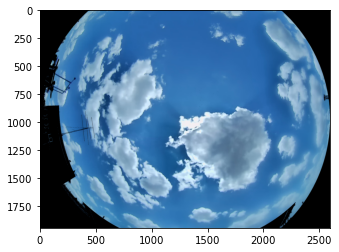

In [13]:
comparacion('Fotos Cielo/imagen_original_2020-06-17-14h34min.jpg')

Obtenemos unos resultados similares en ambos casos, obteniedo un sector 4 con menor radiacion y un sector 3 con una cantidad de nubes elevada, aunque algunas con tonalidad oscura. Observamos que el porcentaje en el sector 3 se reduce debido a que las nubes en este sector no presentan tanta luminancia que los sectores 1 y 2. 

Resultados método Informe 7:
La radiación difusa percibida en el sector 1 del cielo es: 33.49 % del total
La radiación difusa percibida en el sector 2 del cielo es: 15.00 % del total
La radiación difusa percibida en el sector 3 del cielo es: 25.97 % del total
La radiación difusa percibida en el sector 4 del cielo es: 25.58 % del total
El ratio total de radiación cubierto por los sectores es 100.04 %

Resultados método actualizado:
La radiación difusa percibida en el sector 1 del cielo es: 32.75 % de la total
La radiación difusa percibida en el sector 2 del cielo es: 15.31 % de la total
La radiación difusa percibida en el sector 3 del cielo es: 26.10 % de la total
La radiación difusa percibida en el sector 4 del cielo es: 25.87 % de la total
El ratio total de radiación cubierto por los sectores es 100.04 %


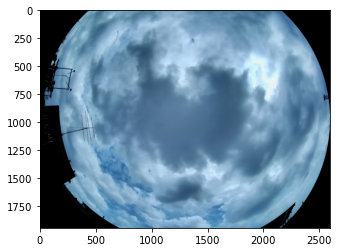

In [14]:
comparacion('Fotos Cielo/imagen_original_2020-06-11-16h49min.jpg')

Por último, una imágen de un cielo que presenta nubes de diferentes tonalidades, tanto muy claras como oscuras. En este tipo de cielos el método actualizado debería presentar unos resultados más acertados, ya que tiene en cuenta la intensidad de los píxeles de las nubes y no la cantidad de nubes que hay en un determinado sector.